### Langchain Agent in V1
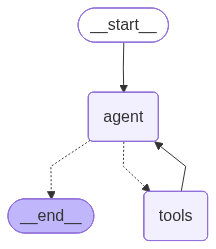

```
from langgraph.prebuilt import create_react_agent

now ->

from langchain.agents import create_agent
```

In [1]:
# use the langchain pre-release for latest features
# pip install --pre -U langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

# Required: pip install langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv

load_dotenv()

# ============================================================================
# LLM & VECTOR STORE SETUP
# ============================================================================
# Ollama LLM with Qwen3
llm = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434"
)

# Ollama Embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# Chroma Vector Store (assumes data already exists from previous code)
vector_store = Chroma(
    collection_name="pdf_collection",
    embedding_function=embeddings,
    persist_directory="..\\01 Semantic Search\\chroma_db"
)

print("✓ Using Ollama qwen3 + nomic-embed-text")
print("✓ Connected to existing Chroma vector store")


✓ Using Ollama qwen3 + nomic-embed-text
✓ Connected to existing Chroma vector store


In [2]:
llm.invoke("Hello")

AIMessage(content='<think>\nOkay, the user said "Hello". I should respond in a friendly and welcoming manner. Let me make sure to acknowledge their greeting and offer assistance. Maybe add an emoji to keep it approachable. I should keep it simple and open-ended so they feel comfortable asking anything. Let me check for any typos or errors. Alright, that should work.\n</think>\n\nHello! 😊 How can I assist you today? I\'m here to help with any questions or tasks you might have!', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-09-21T12:11:43.0938081Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2426048700, 'load_duration': 1615341000, 'prompt_eval_count': 9, 'prompt_eval_duration': 189843100, 'eval_count': 101, 'eval_duration': 616979300, 'model_name': 'qwen3'}, id='run--6bdaf00b-ec50-429e-be3e-0534a7990cd0-0', usage_metadata={'input_tokens': 9, 'output_tokens': 101, 'total_tokens': 110})

In [4]:
# ============================================================================
# VECTOR STORE VERIFICATION
# ============================================================================
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
collection = vector_store._collection
doc_count = collection.count()
print(f"✓ Collection '{collection.name}' found with {doc_count} documents")


# Test 2: Sample similarity search
test_query = "methodology"
results = vector_store.similarity_search(test_query, k=3)
print(f"\n✓ Sample search for '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"  {i}. Page {doc.metadata.get('page', '?')}: {doc.page_content[:100]}...")





🔍 Testing Vector Store Connection...
✓ Collection 'pdf_collection' found with 593 documents

✓ Sample search for 'methodology':
  1. Page 59: involves providing accurate information and transparency about the model’s uncertainty and
limitatio...
  2. Page 60: This method could lead to biased or incomplete feedback due to the diversity of opinions
among label...
  3. Page 103: Method Non-football (DROP) Football (DROP) GSM8k
Zero-Shot 43.86 51.77 16.38
Standard Prompting 58.7...


In [6]:
# results

In [8]:
# ============================================================================
# RETRIEVAL TOOL
# ============================================================================
@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve relevant information from the document to answer the query."""
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search
    docs = vector_store.similarity_search(query, k=4)
    
    # Format for LLM
    content = "\n\n".join(
        f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
        for doc in docs
    )
    
    print(f"✓ Found {len(docs)} relevant chunks")
    return content, docs

# ============================================================================
# AGENT CREATION
# ============================================================================
# Tools for the agent (single tool only)
tools = [retrieve_context]

# Agent prompt - simplified for single tool
prompt = """You are a research assistant with a document retrieval tool.

Tool:
- retrieve_context: Search the document for relevant information

Always use the tool to find relevant information before answering.
Cite page numbers and be thorough."""



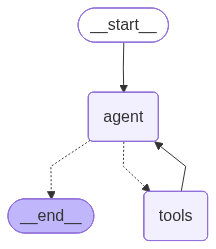

In [9]:
# Create the agentic RAG
rag_agent = create_agent(llm, tools, prompt=prompt)

rag_agent


In [10]:
rag_agent

response = rag_agent.invoke({'messages': "What are the main methods mentioned in this paper?"})

🔍 Searching: 'What are the main methods mentioned in this paper?'
✓ Found 4 relevant chunks


In [11]:
response

{'messages': [HumanMessage(content='What are the main methods mentioned in this paper?', additional_kwargs={}, response_metadata={}, id='a1b8972c-4fa3-46da-bfe1-9a53858018fb'),
  AIMessage(content="<think>\nOkay, the user is asking about the main methods mentioned in the paper. Since I need to use the retrieve_context tool, I should start by calling that function with the query specifically asking for the main methods. The tool will search the document and return relevant information. I should make sure to cite page numbers and be thorough in the answer. Let me check if there are any other parameters needed, but the function only requires the query. Alright, I'll structure the tool call correctly.\n</think>\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-09-21T12:19:59.2848275Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2665051100, 'load_duration': 1627213300, 'prompt_eval_count': 194, 'prompt_eval_duration': 204301000, 'eval_count': 1

In [12]:
# ============================================================================
# QUERY FUNCTION
# ============================================================================
def ask(question: str):
    """Ask the agentic RAG a question."""
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    for event in rag_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using: {tc['name']} with {tc['args']}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")

In [13]:
# ============================================================================
# TESTING
# ============================================================================
# Test basic retrieval
ask("What are the main methods mentioned in this paper?")





Question: What are the main methods mentioned in this paper?

💬 Answer:
What are the main methods mentioned in this paper?

🔧 Using: retrieve_context with {'query': 'What are the main methods mentioned in this paper?'}
🔍 Searching: 'What are the main methods mentioned in this paper?'
✓ Found 4 relevant chunks

💬 Answer:
Page 103: Method Non-football (DROP) Football (DROP) GSM8k
Zero-Shot 43.86 51.77 16.38
Standard Prompting 58.78 62.73 17.06
Chain-of-Thought 74.77 59.56 60.87
Least-to-Most 82.45 73.42 62.39
Table 36: Accuracies of different prompting methods on GSM8k and DROP benchmarks. Source:
Zhou et al. [244]
DECOMP is a text-based prompting strategy that decomposes complex tasks into simpler
subtasks and generates a plan to solve the task, similar to Least-to-Most prompting. The
core idea of Decomposed Prompting involves dividing a complex task into multiple simpler
subtasks. Each subtask is addressed separately using LLMs, and their results are then combined
to produce the final

In [14]:
# ============================================================================
# INTERACTIVE CHAT
# ============================================================================
def chat():
    """Start interactive chat with the agentic RAG."""
    print("\n🤖 Agentic RAG Chat - Type 'quit' to exit")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask(question)

chat()


🤖 Agentic RAG Chat - Type 'quit' to exit

Question: what are methods of RAG?

💬 Answer:
what are methods of RAG?

🔧 Using: retrieve_context with {'query': 'methods of RAG'}
🔍 Searching: 'methods of RAG'
✓ Found 4 relevant chunks

💬 Answer:
Page 122: Benchmarks such as SQuAD [33], Natural Questions [71], and specialized datasets for re-
trieval tasks are widely used for assessment.
Despite its promise, RAG faces several challenges:
1. Retrieval Latency: Efficiently querying large databases in real time remains a technical
hurdle.
2. Data Quality: The reliability of generated outputs depends heavily on the quality of
retrieved data.
3. Scalability: Handling large-scale retrieval tasks while maintaining high generation quality
is complex.
Future research avenues include:
• Expanding RAG frameworks to support multi-modal inputs, such as text, images, and
audio.
• Enhancing retrieval efficiency through novel indexing and search techniques.
• Improving integration mechanisms for tighter cou